In [36]:
import numpy as np
import def_all_CRNs as CRNs
import pandas as pd
from sklearn.linear_model import LinearRegression
from dae_finder import PolyFeatureMatrix
from sklearn.preprocessing import StandardScaler
import sympy
import argparse
import itertools
from dae_finder import get_refined_lib
from dae_finder import AlgModelFinder
from dae_finder import get_simplified_equation_list
from dae_finder import construct_reduced_fit_list
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from dae_finder import solveMM

import matplotlib.pyplot as plt

In [37]:
num_points = 50
noise_perc = 5
t_final = 4

clean_data = CRNs.make_CRN1(5, num_points, t_final)
clean_df = pd.DataFrame(clean_data, columns=['[t]', '[A]', '[B]', '[E1]', '[AE1]'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

In [38]:
tSolve = list(data_matrix_df_list[0]['[t]'])
num_time_points = len(tSolve)

for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["[t]"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=8) # Use trial as RNG seed
        #noisy_data_df = noisy_data_df/noisy_data_df['[A]'].iloc[0]
        noisy_data_df["[t]"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_features = data_matrix_df_list[0].columns
# 3) Smooth noisy data
num_smoothed_points = num_time_points
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                        eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) > 1:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
        data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)


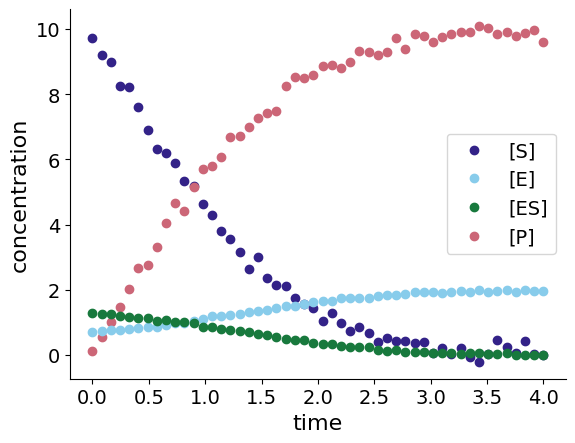

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
data = data_matrix_df_list[0]

colors = ["#332288", "#332288","#CC6677", "#88CCEB", "#18793D"]
labels = ['t', "[S]", "[P]", '[E]', '[ES]']
fig, ax = plt.subplots()
for i, xi in enumerate(data):
    if xi != '[t]':
        ax.plot(data['[t]'], data[xi], 'o', color=colors[i], label=labels[i])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("time", fontsize=16)
plt.ylabel("concentration", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14)
plt.show()
plt.savefig("test.svg")

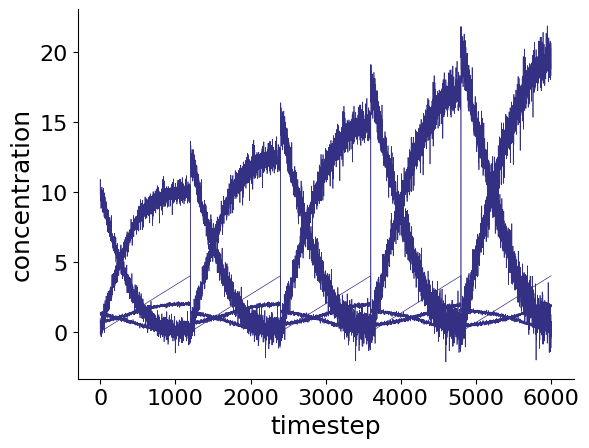

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

data_matrix_df_full = pd.concat(data_matrix_df_list, ignore_index=True)
fig, ax = plt.subplots()

ax.plot(data_matrix_df_full, lw=0.5, color='#343084')
plt.xlabel('timestep', fontsize=18)
plt.ylabel('concentration', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

plt.savefig("sample.svg", bbox_inches='tight')

In [9]:
# 4) Make feature matrix, scale
poly_degree = 4
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

feat_list = list(clean_df.columns)
t, A, B, E1, AE1 = sympy.symbols(feat_list)

In [10]:
candidate_lib_full

,[A],[B],[E1],[AE1],[A]^2,[A] [B],[A] [E1],[A] [AE1],[B]^2,[B] [E1],...,[B]^2 [AE1]^2,[B] [E1]^3,[B] [E1]^2 [AE1],[B] [E1] [AE1]^2,[B] [AE1]^3,[E1]^4,[E1]^3 [AE1],[E1]^2 [AE1]^2,[E1] [AE1]^3,[AE1]^4
0,10.296610,-0.181028,0.720078,1.283164,106.020168,-1.863978,7.414363,13.212237,0.032771,-0.130355,...,0.053958,-0.067590,-0.120445,-0.214630,-0.382466,0.268855,0.479094,0.853736,1.521339,2.710993
1,10.271511,-0.156416,0.720710,1.282266,105.503929,-1.606631,7.402778,13.170807,0.024466,-0.112731,...,0.040227,-0.058555,-0.104179,-0.185353,-0.329774,0.269800,0.480020,0.854038,1.519479,2.703412
2,10.246452,-0.131843,0.721348,1.281364,104.989772,-1.350927,7.391254,13.129432,0.017383,-0.095105,...,0.028540,-0.049487,-0.087906,-0.156152,-0.277380,0.270756,0.480957,0.854347,1.517616,2.695813
3,10.221433,-0.107310,0.721992,1.280458,104.477690,-1.096858,7.379790,13.088111,0.011515,-0.077477,...,0.018880,-0.040386,-0.071626,-0.127029,-0.225286,0.271725,0.481905,0.854663,1.515751,2.688195
4,10.196454,-0.082815,0.722642,1.279547,103.967677,-0.844419,7.368385,13.046845,0.006858,-0.059846,...,0.011229,-0.031252,-0.055336,-0.097982,-0.173491,0.272705,0.482865,0.854986,1.513883,2.680559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.706814,19.355379,1.828173,0.141875,0.499586,13.680651,1.292178,0.100279,374.630697,35.384988,...,7.540751,118.264337,9.177873,0.712246,0.055274,11.170420,0.866877,0.067274,0.005221,0.000405
5996,0.707101,19.355530,1.828392,0.140677,0.499992,13.686317,1.292858,0.099473,374.636524,35.389492,...,7.414051,118.307663,9.102619,0.700358,0.053886,11.175761,0.859866,0.066158,0.005090,0.000392
5997,0.707426,19.355643,1.828579,0.139481,0.500451,13.692684,1.293584,0.098673,374.640919,35.393327,...,7.288662,118.344743,9.027167,0.688579,0.052524,11.180344,0.852821,0.065052,0.004962,0.000378
5998,0.707788,19.355720,1.828735,0.138288,0.500964,13.699751,1.294357,0.097879,374.643881,35.396484,...,7.164578,118.375472,8.951522,0.676912,0.051188,11.184156,0.845743,0.063955,0.004836,0.000366


In [211]:
# 5) Discover conservation law 1
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=True,
                                    alpha=0.2)
algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
best_models_full = algebraic_model_lasso.best_models()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=data_matrix_features,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]

if None in best_relationship:
    best_relationship.remove(None)

# 6) Perform first check: did we find the first law?
if set(best_relationship) != set(['[E1]', '[AE1]']):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


0.9595311543015234


In [212]:
# 5) Discover conservation law 2
_, refined_candid_lib = get_refined_lib({E1}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)
    

In [213]:
# 8) Discover first QSSA 
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[A]', '[A] [AE1]', '[AE1]'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])

***Warning: exception occured while trying to find the monomials of 0.981808682136536:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
False


In [220]:
simplified_equations

{'[A]': {'lhs': [A],
  'rhs': 0.348589665206049*[AE1]*[A] + 3.66430525416361*[AE1]},
 '[A] [AE1]': {'lhs': [AE1], 'rhs': 0.981808682136536},
 '[AE1]^2': {'lhs': [AE1]**2,
  'rhs': 0.56623013068095*[AE1] + 0.0685913508204294*[A]},
 '[AE1]': {'lhs': 1, 'rhs': 0.605508544698272*[AE1]},
 '[A]^2': {'lhs': [A], 'rhs': 8.30849768203347*[AE1]},
 '[A] [B]': {'lhs': [A]*[B],
  'rhs': 8.39785671470685*[AE1]**2 + 4.44802185623242*[AE1]*[B]},
 '[B] [AE1]': {'lhs': [AE1], 'rhs': 0.112826351837543*[A] + 0.184082263158504},
 '[B]^2': {'lhs': [B]**2,
  'rhs': -5.16117606141719*[AE1] + 13.1719255983844*[B]},
 '[B]': {'lhs': [B],
  'rhs': 0.189404771758918*[AE1]*[B] + 1.09631095741533*[AE1] + 0.0556219463504949*[B]**2}}

In [221]:
d_filt # Should be: 1/Etot = 0.5 for [A][AE1], KM/Etot = 2.75 for [AE1]

{'[A] [AE1]': np.float64(0.5076399990379235),
 '[AE1]': np.float64(2.7210009023654007),
 '[A]': inf,
 'intercept': np.float64(0.018979871198802734)}

In [215]:
kcat = 5
kon = 1
koff = .5
Etot = 2.
KM = (koff + kcat)/kon

LHS = data_matrix_df_smooth['[A]']
RHS = (KM/Etot)*data_matrix_df_smooth['[AE1]'] + (1/Etot)*data_matrix_df_smooth['[AE1]']*data_matrix_df_smooth['[A]']

est_Etot_inv = d_filt['[A] [AE1]']
est_KMdivEtot = d_filt['[AE1]']

estLHS = data_matrix_df_smooth['[A]']
estRHS = est_KMdivEtot*data_matrix_df_smooth['[AE1]'] + est_Etot_inv*data_matrix_df_smooth['[AE1]']*data_matrix_df_smooth['[A]'] + d_filt['intercept']

Text(0, 0.5, 'value')

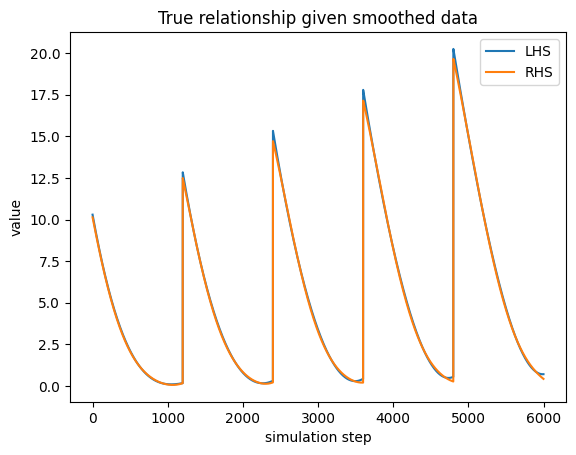

In [216]:
plt.title('True relationship given smoothed data')
plt.plot(LHS, label='LHS')
plt.plot(RHS, label='RHS')
plt.legend()
plt.xlabel("simulation step")
plt.ylabel("value")

Text(0, 0.5, 'value')

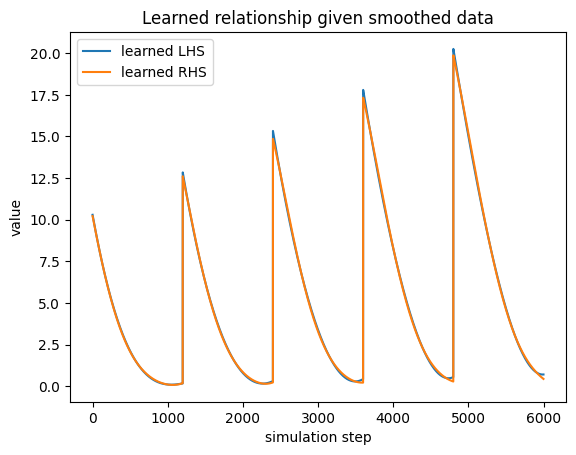

In [217]:
plt.title('Learned relationship given smoothed data')
plt.plot(estLHS, label='learned LHS')
plt.plot(estRHS, label='learned RHS')
plt.legend()
plt.xlabel("simulation step")
plt.ylabel("value")

Text(0, 0.5, 'absolute error')

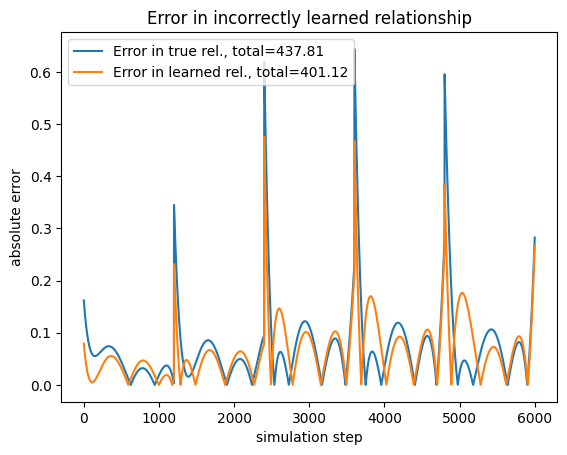

In [218]:
plt.title('Error in incorrectly learned relationship')
plt.plot(abs(LHS-RHS), label=f'Error in true rel., total={sum(abs(LHS-RHS)):.2f}')
plt.plot(abs(estLHS-estRHS), label=f'Error in learned rel., total={sum(abs(estLHS-estRHS)):.2f}')
plt.legend()
plt.xlabel("simulation step")
plt.ylabel("absolute error")